[3.720075976020836e-44, 0.0, 0.0]
0.0 0.0 0.1
0.0 1.3838965267367376e-87 0.1
Epoch 0, Total Loss: 4.662675167917614
Epoch 1000, Total Loss: 0.0001634094599988606
Epoch 2000, Total Loss: 3.8522701765067716e-05
Epoch 3000, Total Loss: 1.1798578745675471e-05
Epoch 4000, Total Loss: 4.5665200147815905e-06
Epoch 5000, Total Loss: 0.000630146536803638
Epoch 6000, Total Loss: 8.933418203171533e-06
Epoch 7000, Total Loss: 0.00011337904560429498
Epoch 8000, Total Loss: 0.00029324011205253165
Epoch 9000, Total Loss: 8.231583903620177e-06
Epoch 10000, Total Loss: 2.2987905017295097e-06
Epoch 11000, Total Loss: 8.05277340239145e-05
Epoch 12000, Total Loss: 2.0772422012267048e-05
Epoch 13000, Total Loss: 2.5052405166713754e-06
Epoch 14000, Total Loss: 0.0002270558421099833
Epoch 15000, Total Loss: 1.0770799188551448e-05
Epoch 16000, Total Loss: 0.00019538784223457783
Epoch 17000, Total Loss: 4.05227816282257e-05
Epoch 18000, Total Loss: 0.00044496554648536664
Epoch 19000, Total Loss: 0.000154290515

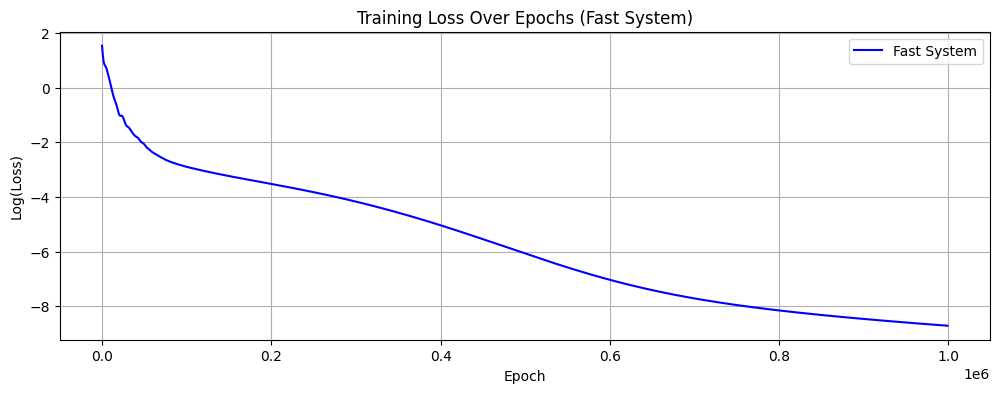

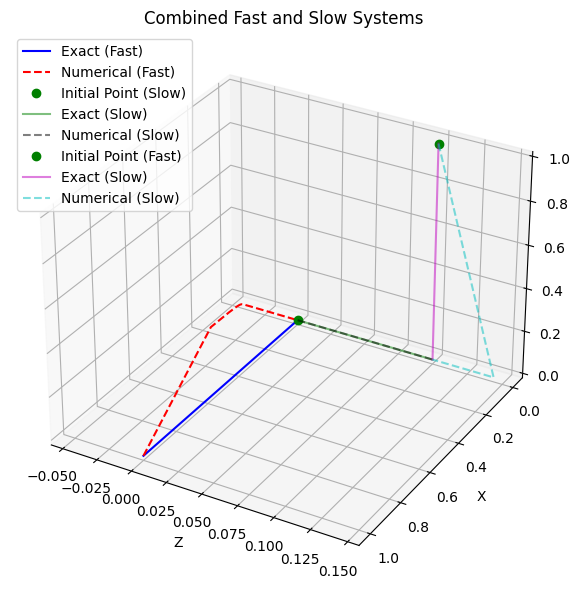

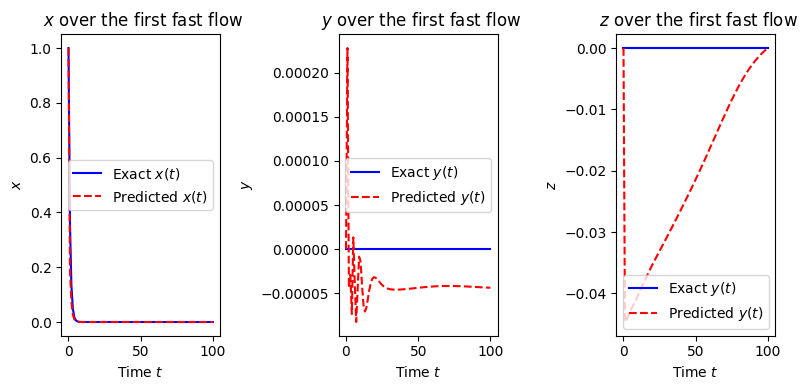

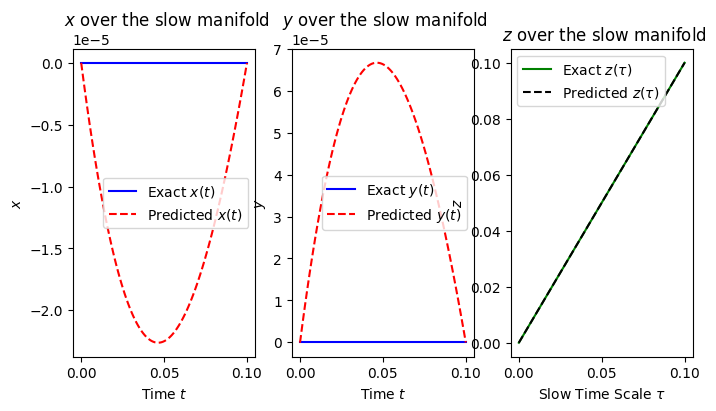

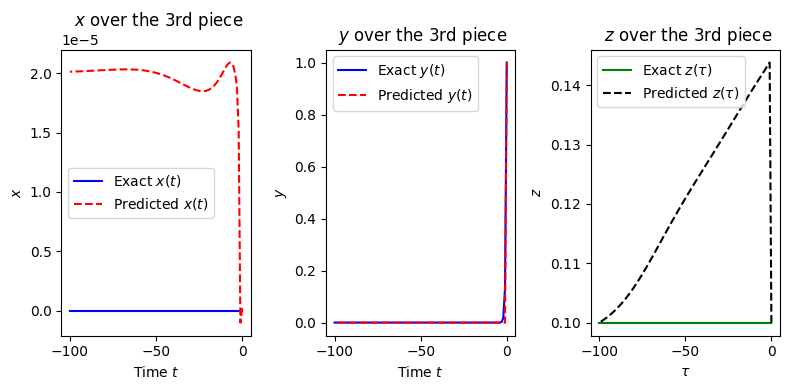

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

# Define the ODE systems
def FastSystem(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y + eps * x
    dzdt = eps * (x**2 + 1)
    return [dxdt, dydt, dzdt]

def Fast_sub_system(y, t, eps):
    x, y, z = y
    dxdt = -x
    dydt = 2 * y
    dzdt = 0
    return [dxdt, dydt, dzdt]

def SlowSystem(y, tau, eps):
    x, y, z = y
    dxdtau = -x/eps
    dydtau = (2 * y + eps * x)/eps
    dzdtau = x**2 + 1
    return [dxdtau, dydtau, dzdtau]

def Slow_sub_system(y, tau, eps):
    x, y, z = y
    dzdtau = x**2 + 1
    return [dzdtau]

# Define the exact solution
#def Fast_solution(t, eps, x0, y0, z0): #Exact full system
#    x_real_fast = x0 * np.exp(-t)
#    y_real_fast =   (np.exp(2 * t)) * (y0 + (eps*x0/3) * (1- np.exp(-3 * t) ) )
#    z_real_fast = (eps *x0**2/2) * (1 - np.exp(-2 * t)) + eps * t + z0
#    return x_real_fast, y_real_fast, z_real_fast

# Define the exact solution
def Fast_solution(t, eps, x0, y0, z0): #sub
    x_real_fast = x0 * np.exp(-t)
    y_real_fast = y0 * np.exp(2 * t)
    z_real_fast = np.full_like(t, z0)
    return x_real_fast, y_real_fast, z_real_fast

def Slow_solution(tau, eps, x1, y1, z1):
    x_real_slow = np.full_like(tau, 0)
    y_real_slow = np.full_like(tau, 0)
    z_real_slow = tau + z1
    return x_real_slow, y_real_slow, z_real_slow

# Initial conditions
x0 = 1
y0 = 0
z0 = 0
t_end = 100
t  =  np.linspace(0, t_end, 100)
tau = np.linspace(0, 0.1, 100)
t2  =  np.linspace(0, -t_end, 100)
eps = 0.001

# Exact solution
x_exact_fast, y_exact_fast, z_exact_fast = Fast_solution(t, eps, x0, y0, z0)


#Over the slow(critical) manifold:
x1 = 0.0
y1 = 0.0
# z1 should be obtained by solving the z-DE of the slow system over the slow manifold
# however, in the following we simplified it as: (need to be rewritten, in general)
x1, y1, z1 = x_exact_fast[-1], y_exact_fast[-1], z_exact_fast[-1]

print([x1,y1,z1])

# Exact solution for the slow system using the final state of the fast system as initial conditions
x_exact_slow, y_exact_slow, z_exact_slow = Slow_solution(tau, eps, x1, y1, z1)
print(x_exact_slow[-1], y_exact_slow[-1], z_exact_slow[-1])

x2, y2, z2 = 0, 1, 0.1
x_exact_fast2, y_exact_fast2, z_exact_fast2 = Fast_solution(t2, eps, x2, y2, z2)
print(x_exact_fast2[-1], y_exact_fast2[-1], z_exact_fast2[-1])

# Transform to tensor
t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
x_real_fast_tensor = torch.tensor(x_exact_fast.reshape(-1, 1), dtype=torch.float64)
y_real_fast_tensor = torch.tensor(y_exact_fast.reshape(-1, 1), dtype=torch.float64)
z_real_fast_tensor = torch.tensor(z_exact_fast.reshape(-1, 1), dtype=torch.float64)

tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
x_real_slow_tensor = torch.tensor(x_exact_slow.reshape(-1, 1), dtype=torch.float64)
y_real_slow_tensor = torch.tensor(y_exact_slow.reshape(-1, 1), dtype=torch.float64)
z_real_slow_tensor = torch.tensor(z_exact_slow.reshape(-1, 1), dtype=torch.float64)

t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)
x_real_fast2_tensor = torch.tensor(x_exact_fast2.reshape(-1, 1), dtype=torch.float64)
y_real_fast2_tensor = torch.tensor(y_exact_fast2.reshape(-1, 1), dtype=torch.float64)
z_real_fast2_tensor = torch.tensor(z_exact_fast2.reshape(-1, 1), dtype=torch.float64)


def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)


class FastSystemPINN(nn.Module):
    def __init__(self):
        super(FastSystemPINN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

class SlowSystemPINN(nn.Module):
    def __init__(self):
        super(SlowSystemPINN, self).__init__()
        self.fc1 = nn.Linear(1, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, tau):
        x = F.tanh(self.fc1(tau))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x



def loss_func_fast(model, t_tensor, x_exact_fast, y_exact_fast, z_exact_fast, x0, y0, z0, x_T, y_T, z_T, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast, z_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1), pred_fast[:, 2].unsqueeze(1)
    ones = torch.ones_like(x_pred_fast, requires_grad=True)  
    dx_dt = torch.autograd.grad(x_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt = torch.autograd.grad(z_pred_fast, t_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast = dx_dt + x_pred_fast
    residual2_fast = dy_dt - 2 * y_pred_fast
    residual3_fast = dz_dt
    #for the main fast system
    residual4_fast = dy_dt - 2 * y_pred_fast - eps * x_pred_fast
    residual5_fast = dz_dt - eps * (x_pred_fast**2 + 1)
    
    init_loss_fast = torch.square(x_pred_fast[0] - x0) + torch.square(y_pred_fast[0] - y0) + torch.square(z_pred_fast[0] - z0)
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 + residual3_fast**2 + residual4_fast**2 + residual5_fast**2)

    random_indices = torch.randint(0, x_exact_fast.shape[0], (random_points,))
    data_loss_fast = torch.mean((x_pred_fast[random_indices] - x_exact_fast[random_indices])**2) + \
                     torch.mean((y_pred_fast[random_indices] - y_exact_fast[random_indices])**2) + \
                    torch.mean((z_pred_fast[random_indices] - z_exact_fast[random_indices])**2)
                          
    #data_loss_fast = torch.mean((x_pred_fast - x_exact_fast)**2) + torch.mean((y_pred_fast - y_exact_fast)**2) + torch.mean((z_pred_fast - z_exact_fast)**2)
     
    boundary_loss_fast = torch.square(x_pred_fast[-1] - x_T) + torch.square(y_pred_fast[-1] - y_T) + torch.square(z_pred_fast[-1] - z_T)
    
    total_loss_fast = physics_loss_fast + init_loss_fast + boundary_loss_fast

    return total_loss_fast

def loss_func_slow(model, tau_tensor, x_exact_slow, y_exact_slow, z_exact_slow, x1, y1, z1, x_TT, y_TT, z_TT, eps, random_points=10):
    tau_tensor.requires_grad = True
    pred_slow = model(tau_tensor)
    x_pred_slow, y_pred_slow, z_pred_slow = pred_slow[:, 0].unsqueeze(1), pred_slow[:, 1].unsqueeze(1), pred_slow[:, 2].unsqueeze(1)
    ones = torch.ones_like(x_pred_slow, requires_grad=True)
    dx_dtau = torch.autograd.grad(x_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dtau = torch.autograd.grad(y_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dtau = torch.autograd.grad(z_pred_slow, tau_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]

    residual1_slow = 0  # dx_dtau + x_pred_slow / eps
    residual2_slow = 0  # dy_dtau - (2 * y_pred_slow + eps * x_pred_slow) / eps
    residual3_slow = dz_dtau - x_pred_slow**2 - 1
    init_loss_slow = torch.square(x_pred_slow[0] - x1) + torch.square(y_pred_slow[0] - y1) + torch.square(z_pred_slow[0] - z1)
    physics_loss_slow = torch.mean(residual1_slow**2 + residual2_slow**2 + residual3_slow**2)

    random_indices = torch.randint(0, x_exact_slow.shape[0], (random_points,))
    data_loss_slow = torch.mean((x_pred_slow[random_indices] - x_exact_slow[random_indices])**2) + \
                     torch.mean((y_pred_slow[random_indices] - y_exact_slow[random_indices])**2) + \
                      torch.mean((z_pred_slow[random_indices] - z_exact_slow[random_indices])**2)
                          
    #data_loss_slow = torch.mean((x_pred_slow - x_exact_slow)**2) + torch.mean((y_pred_slow - y_exact_slow)**2) + torch.mean((z_pred_slow - z_exact_slow)**2)

    boundary_loss_slow = torch.square(x_pred_slow[-1] - x_TT) + torch.square(y_pred_slow[-1] - y_TT) + torch.square(z_pred_slow[-1] - z_TT)
    total_loss_slow = physics_loss_slow + init_loss_slow + boundary_loss_slow
    return total_loss_slow

def loss_func_fast2(model, t2_tensor, x_exact_fast2, y_exact_fast2, z_exact_fast2, x2, y2, z2, x2_T, y2_T, z2_T, eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2, z_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1), pred_fast2[:, 2].unsqueeze(1)
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dz_dt2 = torch.autograd.grad(z_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    #for the sub fast system
    residual1_fast2 = dx_dt2 + x_pred_fast2
    residual2_fast2 = dy_dt2 - 2 * y_pred_fast2
    residual3_fast2 = dz_dt2
    #for the main fast system
    residual4_fast2 = dy_dt2 - 2 * y_pred_fast2 - eps * x_pred_fast2
    residual5_fast2 = dz_dt2 - eps * (x_pred_fast2**2 + 1)
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x2) + torch.square(y_pred_fast2[0] - y2) + torch.square(z_pred_fast2[0] - z2)
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 + residual3_fast2**2 + residual4_fast2**2 + residual5_fast2**2)

    random_indices = torch.randint(0, x_exact_fast.shape[0], (random_points,))
    data_loss_fast2 = torch.mean((x_pred_fast2[random_indices] - x_exact_fast2[random_indices])**2) + \
                     torch.mean((y_pred_fast2[random_indices] - y_exact_fast2[random_indices])**2) + \
                    torch.mean((z_pred_fast2[random_indices] - z_exact_fast2[random_indices])**2)
                          
    
    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - x2_T) + torch.square(y_pred_fast2[-1] - y2_T) + torch.square(z_pred_fast2[-1] - z2_T)
    
    total_loss_fast2 = physics_loss_fast2 + init_loss_fast2 + boundary_loss_fast2

    return total_loss_fast2

def total_loss_func(model_fast, model_slow, model_fast2, t_tensor, tau_tensor, t2_tensor, x_real_fast, y_real_fast, z_real_fast, x_real_slow, y_real_slow, z_real_slow,x_real_fast2, y_real_fast2, z_real_fast2, x0, y0, z0, x1, y1, z1, x2, y2, z2, eps, weight_fast=1.0, weight_slow=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_real_fast, y_real_fast, z_real_fast, x0, y0, z0, x1, y1, z_exact_fast[-1], eps)
    loss_slow = loss_func_slow(model_slow, tau_tensor, x_real_slow, y_real_slow, z_real_slow, x1, y1, z1, x_exact_slow[-1],y_exact_slow[-1],z_exact_slow[-1], eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_real_fast2, y_real_fast2, z_real_fast2, x2, y2, z2, x_exact_slow[-1],y_exact_slow[-1],z_exact_slow[-1], eps)
    total_loss = weight_fast * loss_fast + weight_slow * loss_slow + weight_fast * loss_fast2
    return total_loss


if __name__=='__main__':

    model_fast  = FastSystemPINN().to(torch.float64)  
    model_slow  = SlowSystemPINN().to(torch.float64)
    model_fast2 = FastSystemPINN().to(torch.float64)  
    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_slow.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 1000000

    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_slow, model_fast2, t_tensor, tau_tensor, t2_tensor, x_real_fast_tensor, y_real_fast_tensor, z_real_fast_tensor, x_real_slow_tensor, y_real_slow_tensor, z_real_slow_tensor, x_real_fast2_tensor, y_real_fast2_tensor, z_real_fast2_tensor, x0, y0, z0, x1, y1, z1, x2, y2, z2, eps)
        loss_total.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')
        loss_values.append(loss_total.item())
        
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_slow.eval()
    with torch.no_grad():
        # Predictions for fast system
        x_pred_fast, y_pred_fast, z_pred_fast = model_fast(t_tensor).numpy().T
        # Predictions for slow system
        x_pred_slow, y_pred_slow, z_pred_slow = model_slow(tau_tensor).numpy().T
        # Predictions for fast system
        x_pred_fast2, y_pred_fast2, z_pred_fast2 = model_fast2(t2_tensor).numpy().T
        
    # Plotting the 3D trajectories
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting fast system
    ax.plot(z_exact_fast, x_exact_fast, y_exact_fast, 'b-', label='Exact (Fast)')
    ax.plot(z_pred_fast, x_pred_fast, y_pred_fast, 'r--', label='Numerical (Fast)')

    # Plotting slow system initial point
    ax.plot([z_exact_fast[-1]], [x_exact_fast[-1]], [y_exact_fast[-1]], 'go', label='Initial Point (Slow)')

    # Plotting slow system continuation
    ax.plot(z_exact_slow + z1, x_exact_slow + x1, y_exact_slow + y1, 'g-', label='Exact (Slow)', alpha=0.5)
    ax.plot(z_pred_slow + z1, x_pred_slow + x1, y_pred_slow + x1, 'k--', label='Numerical (Slow)', alpha=0.5)

    # Plotting slow system initial point
    ax.plot(z2, x2, y2, 'go', label='Initial Point (Fast)')

    # Plotting fast system continuation
    ax.plot(z_exact_fast2  , x_exact_fast2  , y_exact_fast2 , 'm-', label='Exact (Slow)', alpha=0.5)
    ax.plot(z_pred_fast2  , x_pred_fast2 , y_pred_fast2 , 'c--', label='Numerical (Slow)', alpha=0.5)

    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    ax.set_title('Combined Fast and Slow Systems')
    ax.legend()
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()
    
    
    #########1st piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.plot(t, x_exact_fast, 'b-', label='Exact $x(t)$')
    plt.plot(t, x_pred_fast, 'r--', label='Predicted $x(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the first fast flow')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(t, y_exact_fast, 'b-', label='Exact $y(t)$')
    plt.plot(t, y_pred_fast, 'r--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the first fast flow')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(t, z_exact_fast, 'b-', label='Exact $y(t)$')
    plt.plot(t, z_pred_fast, 'r--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$z$')
    plt.title(' $z$ over the first fast flow')
    plt.legend()
    

    plt.tight_layout()
    plt.show()
    
    ########2nd piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.plot(tau, x_exact_slow + x_exact_fast[-1], 'b-', label='Exact $x(t)$')
    plt.plot(tau, x_pred_slow + x_exact_fast[-1], 'r--', label='Predicted $x(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the slow manifold')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(tau, y_exact_slow + y_exact_fast[-1], 'b-', label='Exact $y(t)$')
    plt.plot(tau, y_pred_slow + y_exact_fast[-1], 'r--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the slow manifold')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(tau, z_exact_slow + z_exact_fast[-1], 'g-', label='Exact $z(\\tau)$')
    plt.plot(tau, z_pred_slow + z_exact_fast[-1], 'k--', label='Predicted $z(\\tau)$')
    plt.xlabel('Slow Time Scale $\\tau$')
    plt.ylabel('$z$')
    plt.title(' $z$ over the slow manifold')
    plt.legend()
    
    ########3rd piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.plot(t2, x_exact_fast2 , 'b-', label='Exact $x(t)$')
    plt.plot(t2, x_pred_fast2 , 'r--', label='Predicted $x(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the 3rd piece')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(t2, y_exact_fast2 , 'b-', label='Exact $y(t)$')
    plt.plot(t2, y_pred_fast2 , 'r--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the 3rd piece')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(t2, z_exact_fast2  , 'g-', label='Exact $z(\\tau)$')
    plt.plot(t2, z_pred_fast2 , 'k--', label='Predicted $z(\\tau)$')
    plt.xlabel('$\\tau$')
    plt.ylabel('$z$')
    plt.title(' $z$ over the 3rd piece')
    plt.legend()
    

    plt.tight_layout()
    plt.show()

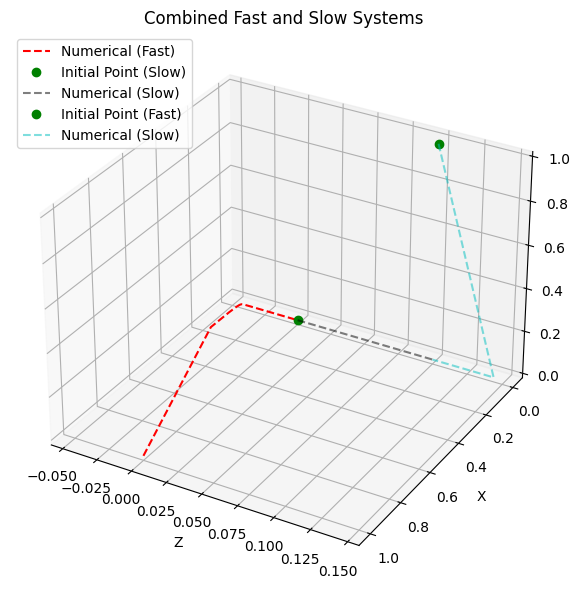

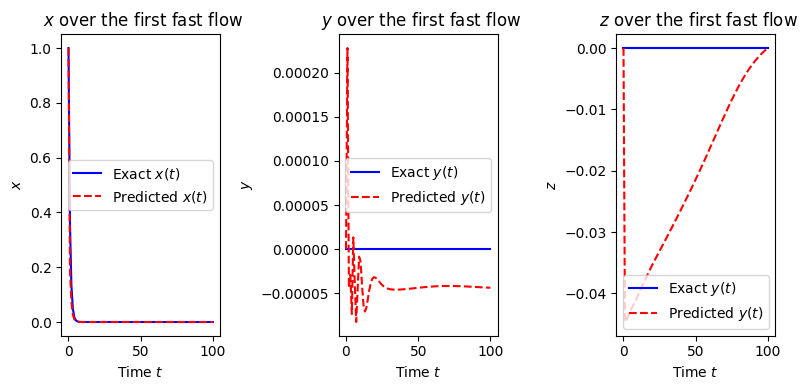

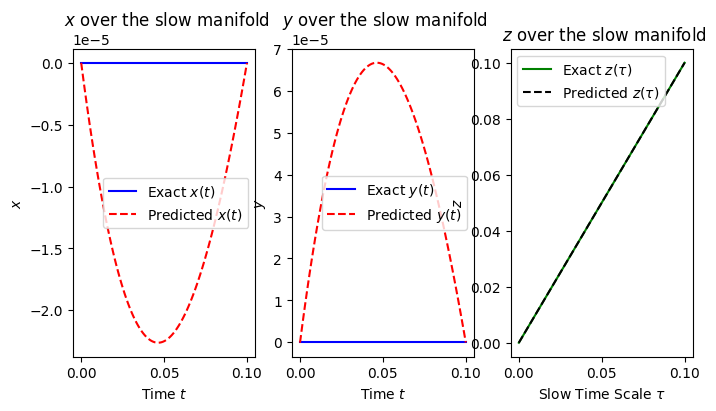

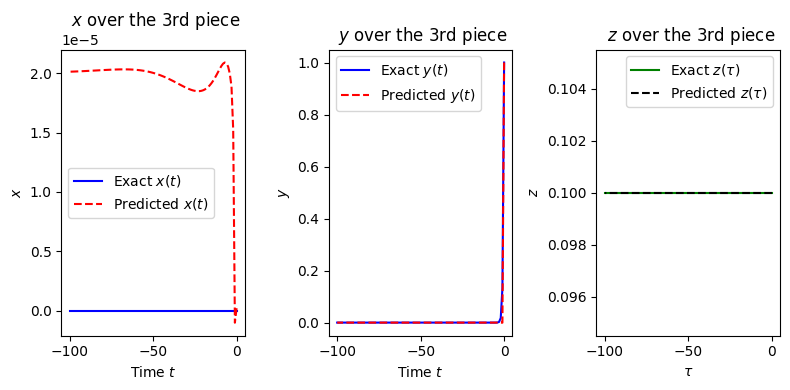

In [2]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotting fast system
#ax.plot(z_exact_fast, x_exact_fast, y_exact_fast, 'b-', label='Exact (Fast)')
ax.plot(z_pred_fast, x_pred_fast, y_pred_fast, 'r--', label='Numerical (Fast)')

# Plotting slow system initial point
ax.plot([z_exact_fast[-1]], [x_exact_fast[-1]], [y_exact_fast[-1]], 'go', label='Initial Point (Slow)')

# Plotting slow system continuation
#ax.plot(z_exact_slow + z1, x_exact_slow + x1, y_exact_slow + y1, 'g-', label='Exact (Slow)', alpha=0.5)
ax.plot(z_pred_slow + z1, x_pred_slow + x1, y_pred_slow + x1, 'k--', label='Numerical (Slow)', alpha=0.5)

# Plotting slow system initial point
ax.plot(z2, x2, y2, 'go', label='Initial Point (Fast)')

# Plotting fast system continuation
#ax.plot(z_exact_fast2  , x_exact_fast2  , y_exact_fast2 , 'm-', label='Exact (Slow)', alpha=0.5)
ax.plot(z_pred_fast2  , x_pred_fast2 , y_pred_fast2 , 'c--', label='Numerical (Slow)', alpha=0.5)

ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_zlabel('Y')
ax.set_title('Combined Fast and Slow Systems')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.show()

#########1st piece
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.plot(t, x_exact_fast, 'b-', label='Exact $x(t)$')
plt.plot(t, x_pred_fast, 'r--', label='Predicted $x(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$x$')
plt.title(' $x$ over the first fast flow')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(t, y_exact_fast, 'b-', label='Exact $y(t)$')
plt.plot(t, y_pred_fast, 'r--', label='Predicted $y(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$y$')
plt.title(' $y$ over the first fast flow')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t, z_exact_fast, 'b-', label='Exact $y(t)$')
plt.plot(t, z_pred_fast, 'r--', label='Predicted $y(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$z$')
plt.title(' $z$ over the first fast flow')
plt.legend()


plt.tight_layout()
plt.show()

########2nd piece
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.plot(tau, x_exact_slow + x_exact_fast[-1], 'b-', label='Exact $x(t)$')
plt.plot(tau, x_pred_slow + x_exact_fast[-1], 'r--', label='Predicted $x(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$x$')
plt.title(' $x$ over the slow manifold')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(tau, y_exact_slow + y_exact_fast[-1], 'b-', label='Exact $y(t)$')
plt.plot(tau, y_pred_slow + y_exact_fast[-1], 'r--', label='Predicted $y(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$y$')
plt.title(' $y$ over the slow manifold')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(tau, z_exact_slow + z_exact_fast[-1], 'g-', label='Exact $z(\\tau)$')
plt.plot(tau, z_pred_slow + z_exact_fast[-1], 'k--', label='Predicted $z(\\tau)$')
plt.xlabel('Slow Time Scale $\\tau$')
plt.ylabel('$z$')
plt.title(' $z$ over the slow manifold')
plt.legend()

########3rd piece
plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.plot(t2, x_exact_fast2, 'b-', label='Exact $x(t)$')
plt.plot(t2, x_pred_fast2 , 'r--', label='Predicted $x(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$x$')
plt.title(' $x$ over the 3rd piece')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(t2, y_exact_fast2 , 'b-', label='Exact $y(t)$')
plt.plot(t2, y_pred_fast2 , 'r--', label='Predicted $y(t)$')
plt.xlabel('Time $t$')
plt.ylabel('$y$')
plt.title(' $y$ over the 3rd piece')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(t2, z_exact_fast2 , 'g-', label='Exact $z(\\tau)$')
plt.plot(t2, z_exact_fast2 , 'k--', label='Predicted $z(\\tau)$')
plt.xlabel('$\\tau$')
plt.ylabel('$z$')
plt.title(' $z$ over the 3rd piece')
plt.legend()


plt.tight_layout()
plt.show()